## Ensemble notebook

We make an ensemble of our 3 best performing models (XGBoost, LightGBM, CatBoost) using StackingRegressor.  This model achieves a RMSLE of 0.05879, which is 678/4318 in the Kaggle competition.  A residual plot is created.  Interpretability comes via SHAP values of each individual model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

StackingRegressor + RidgeCV RMSE (train): 0.05325726374579366
StackingRegressor + RidgeCV RMSE (test): 0.05922175555202869


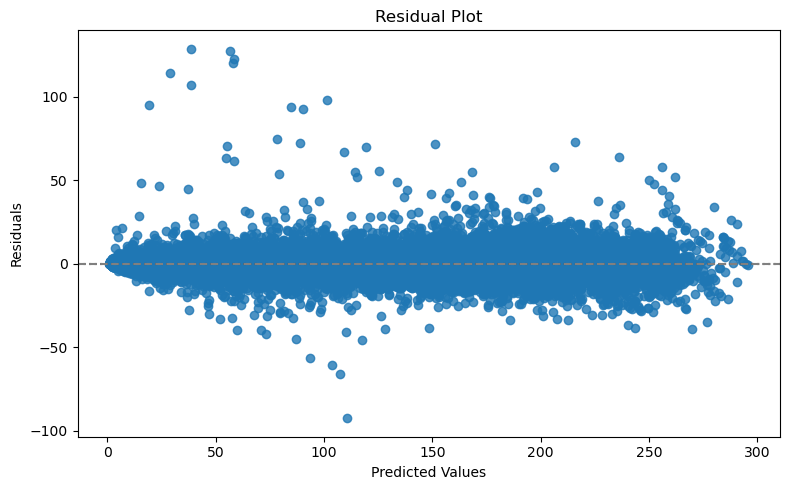

       id    Calories
0  750000   27.493684
1  750001  107.918616
2  750002   87.399020
3  750003  125.817821
4  750004   76.011517

count    250000.000000
mean         88.180479
std          62.273122
min           0.998186
25%          34.005695
50%          76.460730
75%         135.381910
max         295.593276
Name: Calories, dtype: float64


In [ ]:
# Load and split data
y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)
test_mod = add_feats(test, numerical_features)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=724
)

# Define base (level-0) regressors
# all parameters are selected in their corresponding files

xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    reg_lambda=3.3114e-07,
    reg_alpha=0.3825,
    subsample=0.8,
    colsample_bytree=0.3904,
    max_depth=8,
    min_child_weight=5,
    learning_rate=0.01,
    gamma=4.3686e-05,
    grow_policy='depthwise',
    n_estimators=1331,
    verbosity=0,
    random_state=724,
    eval_metric='rmse',
    enable_categorical=True
)

lgbm_reg = LGBMRegressor(
    learning_rate=0.005,
    # subsample=0.8,
    reg_alpha=1.0634452742400607e-05,  # same as lambda_l1
    reg_lambda=0.007514325347682328, # same as lambda_l2
    num_leaves=325,
    feature_fraction=0.5061026371000865,
    bagging_fraction=0.8, # same as subsample
    bagging_freq=4,
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1865,
    verbose=-1,
)

cb_reg = CatBoostRegressor(
    iterations=1836,
    depth=12,
    learning_rate=0.015,
    l2_leaf_reg=0.00011954668586223026,
    bagging_temperature=4.475008023561076e-05,
    border_count=133,
    grow_policy="SymmetricTree",
    #task_type='GPU',
    eval_metric='RMSE',
    loss_function='RMSE',
    random_state=724,
    verbose=0,
    # early_stopping_rounds=40,
    # use_best_model=True,
    cat_features=['Sex']
)

base_estimators = [
    ('xgb', xgb_reg),
    ('lgbm', lgbm_reg),
    ('cb', cb_reg)
]

# Build the stacking regressor
stack = StackingRegressor(
    estimators=base_estimators,
    final_estimator=RidgeCV(alphas=[0.01, 0.1, 1.0, 10]),  # meta-learner
    cv=3,                        # folds for out-of-fold predictions
    n_jobs=-1,                   # parallelize training
    passthrough=False            # if True, original features are concatenated with base preds
)

# Train and evaluate
stack.fit(X_train, y_train)
y_pred_train = stack.predict(X_train)
y_pred_test = stack.predict(X_test)
error_train = rmse(y_train, y_pred_train)
error_test = rmse(y_test, y_pred_test)

print(f"StackingRegressor + RidgeCV RMSE (train): {error_train}")
print(f"StackingRegressor + RidgeCV RMSE (test): {error_test}")


# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(y_pred_test), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# private score 0.05879, public 0.05709, 678/4318 ensemble_prediction_5.csv

# make the submission file!
pred = stack.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("ensemble_prediction_5.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [16]:
print("The model weights are:")
print("XGBoost:", stack.final_estimator_.coef_[0])
print("LightGBM:", stack.final_estimator_.coef_[1])
print("CatBoost:", stack.final_estimator_.coef_[2])

The model weights are:
XGBoost: 0.28300876703762556
LightGBM: 0.2062864564796707
CatBoost: 0.5108608924437048


We can reference the SHAP values for each individual model to understand the performance of the ensemble model.